In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import re

import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('sentiment_data_stemmatized_merged.csv')
df.head()

,Unnamed: 0,text,label,target
0,0,go feel hopeless damn hope around someon care ...,sadness,1
1,1,im grab minut post feel greedi wrong,anger,0
2,2,ever feel nostalg fireplac know still properti,love,4
3,3,feel grouchi,anger,0
4,4,ive feel littl burden late wasnt sure,sadness,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19997 non-null  int64 
 1   text        19997 non-null  object
 2   label       19997 non-null  object
 3   target      19997 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 625.0+ KB


In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

<AxesSubplot:xlabel='label', ylabel='count'>

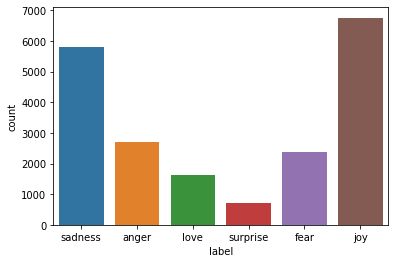

In [6]:
sns.countplot(df['label'])

#### Looks like Dataset is quite unbalanced, we have less values for ''surprise'' target. We will startify while splitting so that our model doesn't gets more biased.

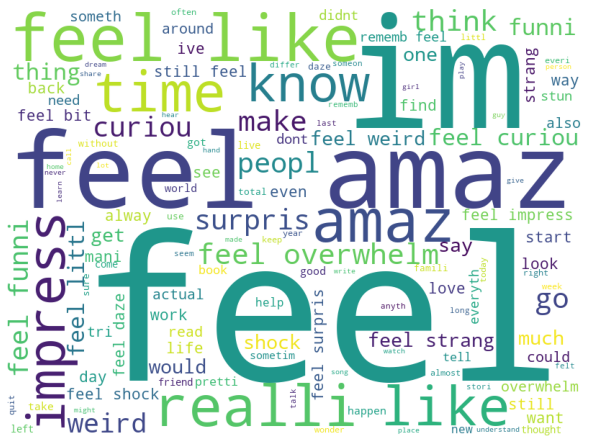

In [13]:
#wordcloud for 'Surprise' target
wordcloud = WordCloud(height=600,width=800,
                      background_color='white',min_font_size=10,
                      stopwords=stopwords.words('english')).generate(' '.join(df[df['label']=='surprise'].text))
# plot the word cloud for fake news data                      
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### We can see in above the occurences of words like amazed, impress, overwhelmed are more which denotes surprised.

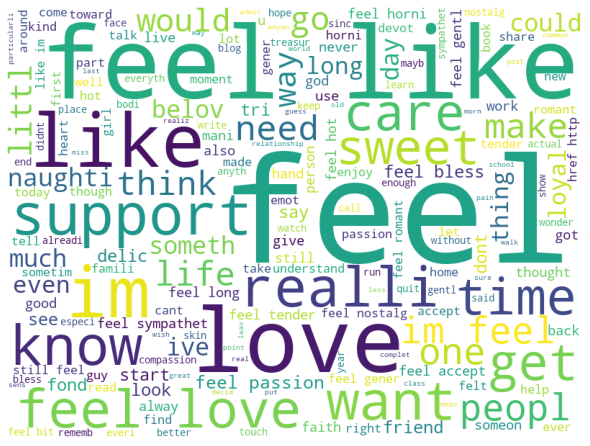

In [14]:
#wordcloud for 'love' target
wordcloud = WordCloud(height=600,width=800,
                      background_color='white',min_font_size=10,
                      stopwords=stopwords.words('english')).generate(' '.join(df[df['label']=='love'].text))
# plot the word cloud for fake news data                      
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### We can see the occurences of words like love, care, support, friend, faith etc are present which defines love.

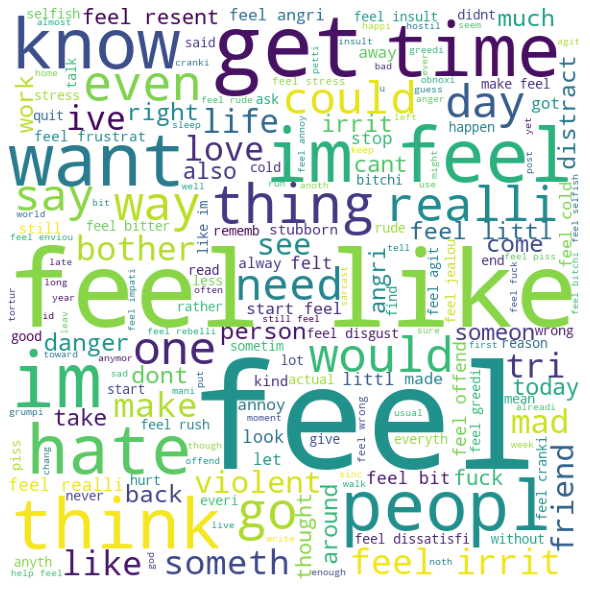

In [15]:
#wordcloud for 'Surprise' target
wordcloud = WordCloud(height=600,width=600,
                      background_color='white',min_font_size=10,
                      stopwords=stopwords.words('english')).generate(' '.join(df[df['label']=='anger'].text))
# plot the word cloud for fake news data                      
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### Words like irritate, anger, insult can be seen which denotes anger.

<hr style="background:black;border:1px solid black;"></hr>

## Creating Word Embeddings for RNN

- <span style='font-weight:bold;'>Word Embeddings</span>: represent a word with a low-dimensional vector (e.g. 100 dimensions). The dimensions are usually latent, and often obtained using the information as in the distributional semantics approach (e.g. LSA, word2vec).

#### Steps to create word Embeddings
<ol>
    <li>Initalize vocabulary size & convert corpus to One Hot representation.</li>
    <li>Initalize sentence length & apply padding to the one hot representation created.</li>
    <li>Passing all these to the Embedding layers.</li>
</ol>

In [17]:
# Converting corpus  ('text') to one_hot representation
vocab_size = 20000
onehot_repr = [one_hot(words,vocab_size) for words in df['text']]
onehot_repr[:5]

[[739, 1176, 11902, 2251, 12033, 19568, 5023, 19526, 17797],
 [9955, 12797, 18052, 11501, 1176, 3309, 14505],
 [2105, 1176, 16464, 560, 12232, 13439, 19322],
 [1176, 19059],
 [11336, 1176, 761, 19339, 18875, 10162, 16663]]

In [24]:
# Initalizing sentence length and applying padding to onehot_repr
sent_length = 25
embedded_docs = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
embedded_docs[9999:10001]

array([[    0,     0,     0,     0,     0,     0,     0,     0,  6088,
         1176, 19727,  6324,  4433,  7758, 11115,   116,  5750,  4433,
         4444,   739,  7406,  2147, 12694,   729,   564],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 14531,
         1923,  9955,  1176, 17553,  9052,  9701,  6314]])

## Preparing Model, Splitting data & Training

In [148]:
#Preparing Model

embedding_vector_features = 50
model = Sequential([
    Embedding(vocab_size,embedding_vector_features,input_length=sent_length),
    Dropout(0.3),
    LSTM(128),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dropout(0.4),
    Dense(6,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 25, 50)            1000000   
_________________________________________________________________
dropout_22 (Dropout)         (None, 25, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 6)               

In [152]:
#Defining callbacks

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             patience=2,
                             min_lr=0.0001)
callbacks = [reducelr]

In [140]:
#Splitting Data

X = np.array(embedded_docs)
y = df['target']
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (19997, 25)
y shape: (19997,)


In [141]:
trainX,testX,trainY,testY = train_test_split(X,y,random_state=21,stratify=y,test_size=0.25)
print('trainX shape: {}'.format(trainX.shape))
print('testX shape: {}'.format(testX.shape))

trainX shape: (14997, 25)
testX shape: (5000, 25)


In [162]:
# Training Model

history = model.fit(trainX,trainY,validation_data=(testX,testY),batch_size=32,epochs=10,callbacks=callbacks)

Epoch 1/10
938/938 [==============================] - 39s 41ms/step - loss: 0.0763 - accuracy: 0.9727 - val_loss: 0.5533 - val_accuracy: 0.8746
Epoch 2/10
938/938 [==============================] - 35s 38ms/step - loss: 0.0782 - accuracy: 0.9705 - val_loss: 0.5124 - val_accuracy: 0.8726
Epoch 3/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0742 - accuracy: 0.9738 - val_loss: 0.5297 - val_accuracy: 0.8730
Epoch 4/10
938/938 [==============================] - 34s 36ms/step - loss: 0.0690 - accuracy: 0.9747 - val_loss: 0.6001 - val_accuracy: 0.8724
Epoch 6/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0685 - accuracy: 0.9744 - val_loss: 0.5855 - val_accuracy: 0.8724
Epoch 7/10
938/938 [==============================] - 33s 36ms/step - loss: 0.0658 - accuracy: 0.9773 - val_loss: 0.5967 - val_accuracy: 0.8704
Epoch 8/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0638 - accuracy: 0.9781 - val_loss: 0.6021 - val_accuracy:

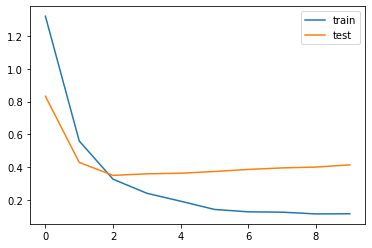

In [155]:
#Plotting losses
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [156]:
#Prediction
pred = model.predict(testX)

In [157]:
#Transforming one_hot encoded output values to respective integers
predictions = np.array([np.argmax(np.round(x)) for x in pred])

In [158]:
predictions[:5]

array([3, 3, 1, 3, 3], dtype=int64)

Accuracy: 87.6%

Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.92      0.86       677
           1       0.94      0.90      0.92      1449
           2       0.87      0.81      0.84       593
           3       0.91      0.90      0.91      1691
           4       0.74      0.74      0.74       410
           5       0.73      0.81      0.77       180

    accuracy                           0.88      5000
   macro avg       0.83      0.85      0.84      5000
weighted avg       0.88      0.88      0.88      5000


Confusion matrix: 

 AxesSubplot(0.125,0.125;0.62x0.755)


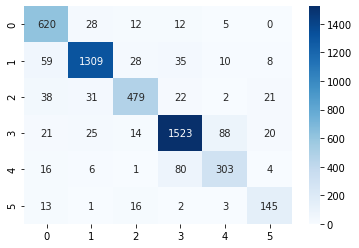

In [160]:
# Accuracy, confusion_matrix,classification_report
print('Accuracy: {}%'.format(round(accuracy_score(testY,predictions),3)*100))
print('\nClassification Report: \n\n {}'.format(classification_report(testY,predictions)))
conf_mat = np.round(confusion_matrix(testY,predictions))
print('\nConfusion matrix: \n\n {}'.format(sns.heatmap(conf_mat,annot=True,cmap='Blues',fmt='g')))